# Monte-Carlo Case Study using Nigeria's Power Data
This Jupyter Notebook serves as a case study for analyzing simulations created using Monte-Carlo method applied to Nigeria's power data.

## Introduction

The goal of this notebook is to analyze the results of the Monte-Carlo simulations and gain insights into the power system of Nigeria. It utilizes the Monte Carlo method to generate multiple scenarios and assess the uncertainty in the power system's performance.

The Monte Carlo method is a statistical technique that involves running multiple simulations with randomly sampled input parameters to estimate the distribution of the output variables. By applying this method to Nigeria's power data, we can assess the reliability and robustness of the power system under different scenarios and identify potential areas for improvement.

## Notebook Structure

This notebook is structured as follows:

1. Getting Started: Enable Monte-Carlo in pypsa-earth and setting the configurations.
2. Data Preparation: Importing necessary libraries and loading results of the simulations.
3. Simulation Analysis: Analyzing the results of the Monte-Carlo simulations.
4. Conclusion: Summarizing the findings and insights from the analysis.

By following this notebook, you will be able to understand the applied Monte-Carlo methodology, explore the power system simulations, and gain insights into Nigeria's power data.


## Getting Started

To get started with apply Monte-Carlo simulation to pypsa-earth energy modelling tool, in the `config.yaml` file, set `add_to_snakefile` to true in the monte_carlo section. This will enable the monte-carlo option.

- Choose the number of samples for the monte-carlo simulations.
- Select the sampling strategy to use from `chaospy`, `pydoe2`, or `scipy`.
- Set seed for reproducibility.

Under the `uncertainties` section, users can add flexibly features for the Monte-Carlo sampling using the description below
  - {pypsa network object, e.g. "loads_t.p_set"}:
  - type: {any distribution among: "uniform", "normal", "lognormal", "triangle", "beta" and "gamma"}
  - args: {arguments passed as a list depending on the distribution, see arguments description in Chaospy reference guide (https://chaospy.readthedocs.io/en/master/reference/distribution/index.html)}

This is an example of the monte-carlo options in the config file.

```python
monte_carlo:
  options:
    add_to_snakefile: true
    samples: 49 # number of optimizations. Note that number of samples when using scipy has to be the square of a prime number
    sampling_strategy: "chaospy"  # "pydoe2", "chaospy", "scipy", packages that are supported
    seed: 42 # set seedling for reproducibilty
  uncertainties:
    loads_t.p_set:
      type: beta
      args: [2, 0.5]
    generators_t.p_max_pu.loc[:, n.generators.carrier == "solar"]:
      type: beta
      args: [4, 1]
    generators_t.p_max_pu.loc[:, n.generators.carrier == "onwind"]:
      type: beta
      args: [4, 1]
    generators.capital_cost.loc[n.generators.carrier == "solar"]:
      type: normal
      args: [0, 1]
    generators.capital_cost.loc[n.generators.carrier == "onwind"]:
      type: normal
      args: [0, 1]
    generators.weight.loc[n.generators.carrier == "onwind"]:
      type: beta
      args: [2, 0.5]
    generators.weight.loc[n.generators.carrier == "solar"]:
      type: beta
      args: [2, 0.5]
```

To generate a DAG for the Monte-Carlo workflow, run `snakemake -j1 solve_all_networks_monte --dag > workflow.dot`. This should create a `workflow.dot` file in your directory. 

Inspect the first line in the `workflow.dot` file, if the first line has something of this sort `Restricted license - for non-production use only - expires 2025-11-24`, then remove the first line. Then run `dot workflow.dot -Tpng -o workflow.png` to create a `png` file from `workflow.dot` file.

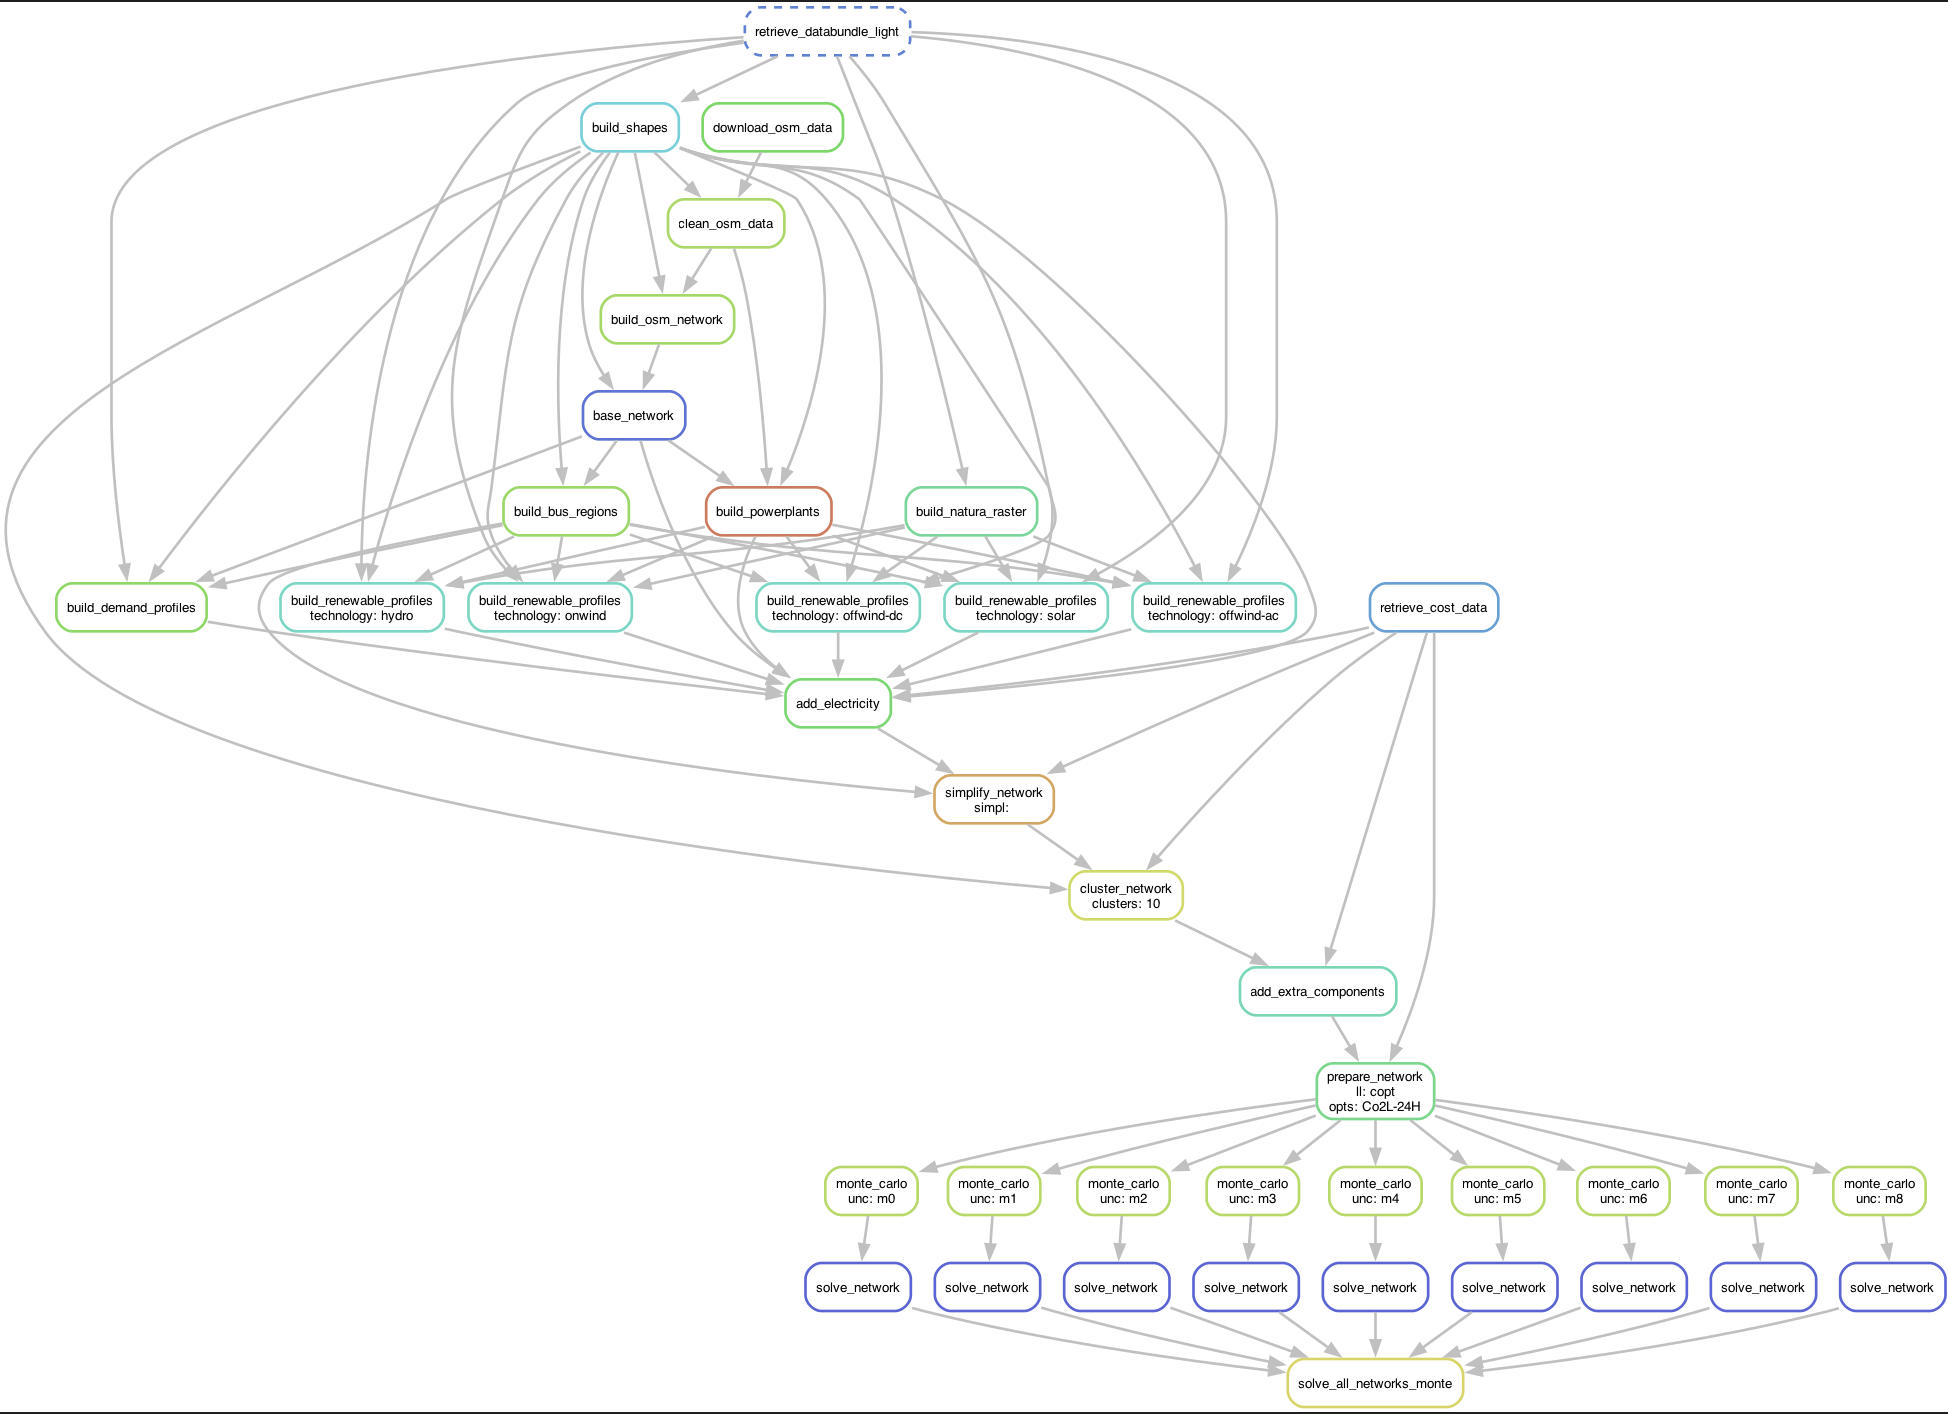

To run the workflow with a dryrun after activating the option in `config.yaml` file, run `snakemake -j1 solve_all_networks_monte -n`. To run the workflow without the dryrun, you can remove the `-n` option from the command.


### Loading Neccessary Libraries

In [1]:
import os
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import logging
    
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

pd.set_option('display.max_columns', 500)

/Users/gbotemi/miniconda3/envs/pypsa-earth-v2/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


### Loading simulation results

In [4]:
network_list = []

for count in range(0,49):
    path = f"results/NG/networks/elec_s_10_ec_lcopt_Co2L-24H_m{count}.nc"
    network = pypsa.Network(path)
    network_list.append(network)

print(f"All Networks loaded successfully")

All Networks loaded successfully


In [5]:
network_obejective_list = []

for idx in network_list:
    obj = idx.objective / 1e9
    network_obejective_list.append(obj)
print("objective loaded completely")

objective loaded completely


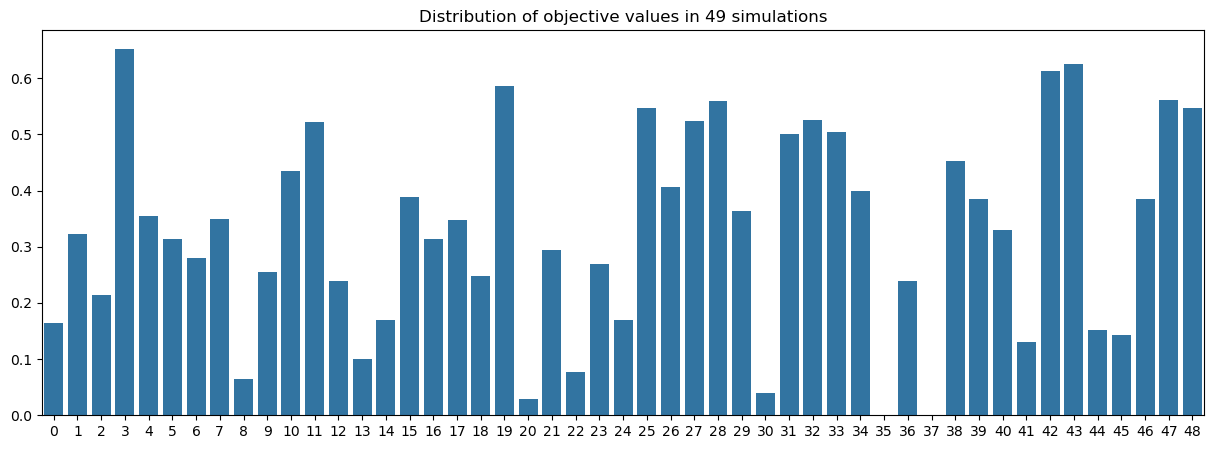

In [22]:
plt.figure(figsize=(15,5))
sns.barplot(network_obejective_list)
plt.title("Distribution of objective values in 49 simulations")
plt.show()

In [48]:
# network index with the least objective value
network_obejective_list.index(min(network_obejective_list))

37

In [8]:
# network index with the max objective value
network_obejective_list.index(max(network_obejective_list))

3

The highest objective value is with index 3, while the lowest is with index 37

In [9]:
network_obejective_constant_list = []

for idx in network_list:
    obj = idx.objective_constant / 1e9
    network_obejective_constant_list.append(obj)
logging.info("objective constant loaded completely")

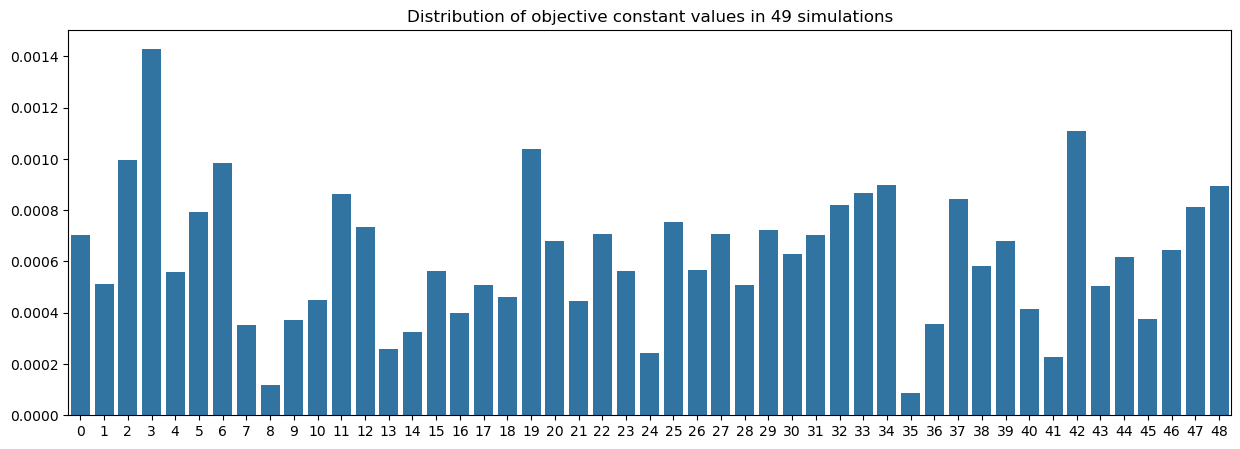

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(network_obejective_constant_list)
plt.title("Distribution of objective constant values in 49 simulations")
plt.show()

In [11]:
load_list = []
for idx in network_list:
    load = idx.loads_t.p_set.sum().sum()
    load_list.append(load)
logging.info("load loaded completely")


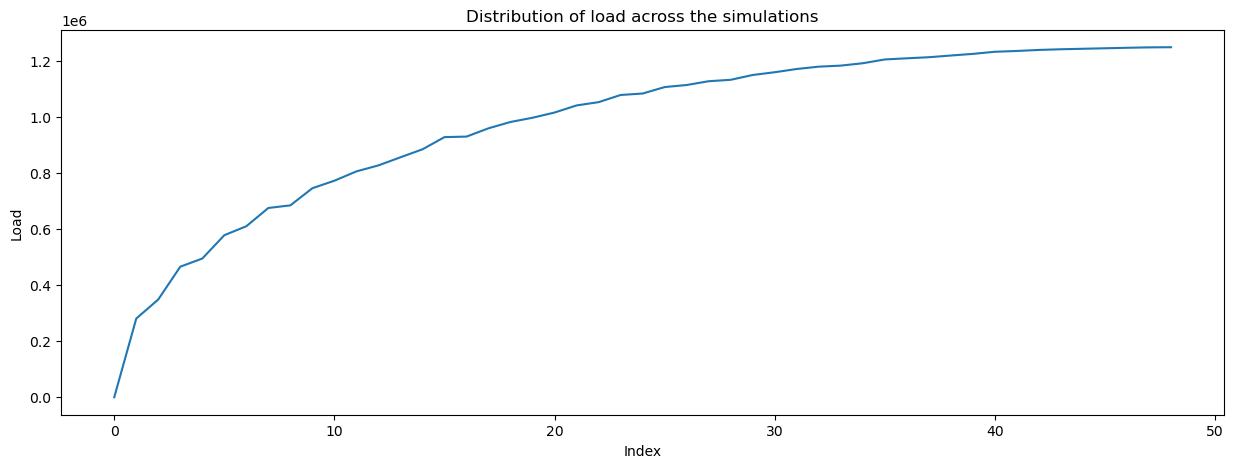

In [12]:
plt.figure(figsize=(15,5))
plt.plot(range(len(load_list)), sorted(load_list))
plt.title("Distribution of load across the simulations")
plt.xlabel("Index")
plt.ylabel("Load")
plt.show()


six networks (three networks with the least objective values and three networks with the top objective values) are selected from the simulations for the rest of the analysis

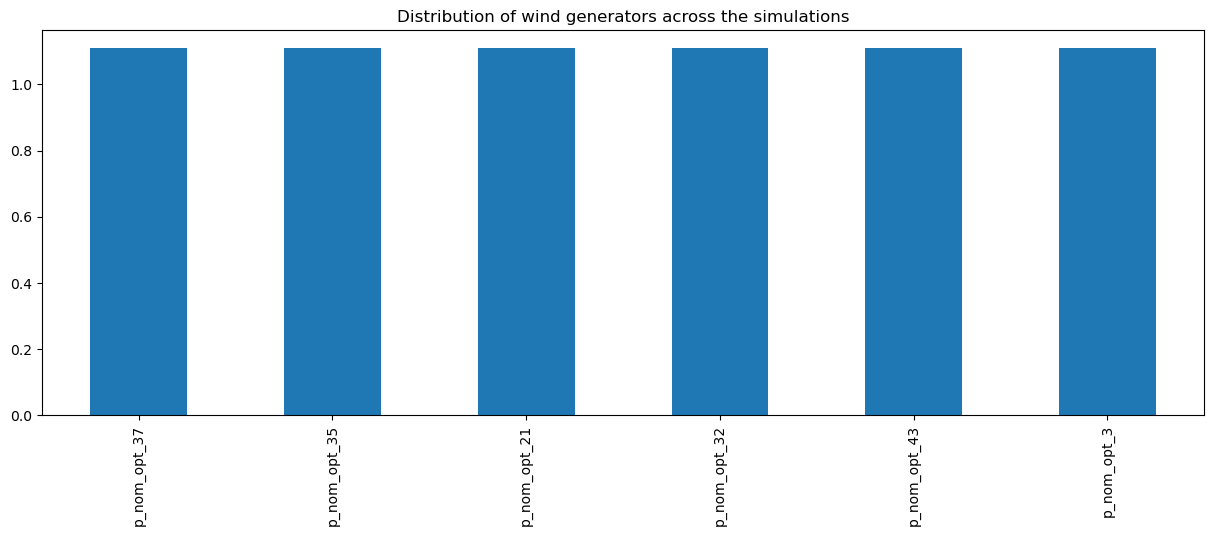

In [73]:
wind_generators = pd.concat([network_list[37].generators[network_list[37].generators.index.str.contains('onwind')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_37"}),
                             network_list[35].generators[network_list[35].generators.index.str.contains('onwind')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_35"}),
                             network_list[21].generators[network_list[21].generators.index.str.contains('onwind')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_21"}),
                             network_list[32].generators[network_list[32].generators.index.str.contains('onwind')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_32"}),
                             network_list[43].generators[network_list[43].generators.index.str.contains('onwind')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_43"}),
                             network_list[3].generators[network_list[3].generators.index.str.contains('onwind')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_3"})],
                            axis=1)
wind_generators.sum().plot(kind="bar", figsize=(15,5))
plt.title("Distribution of wind generators across the simulations")
plt.show()

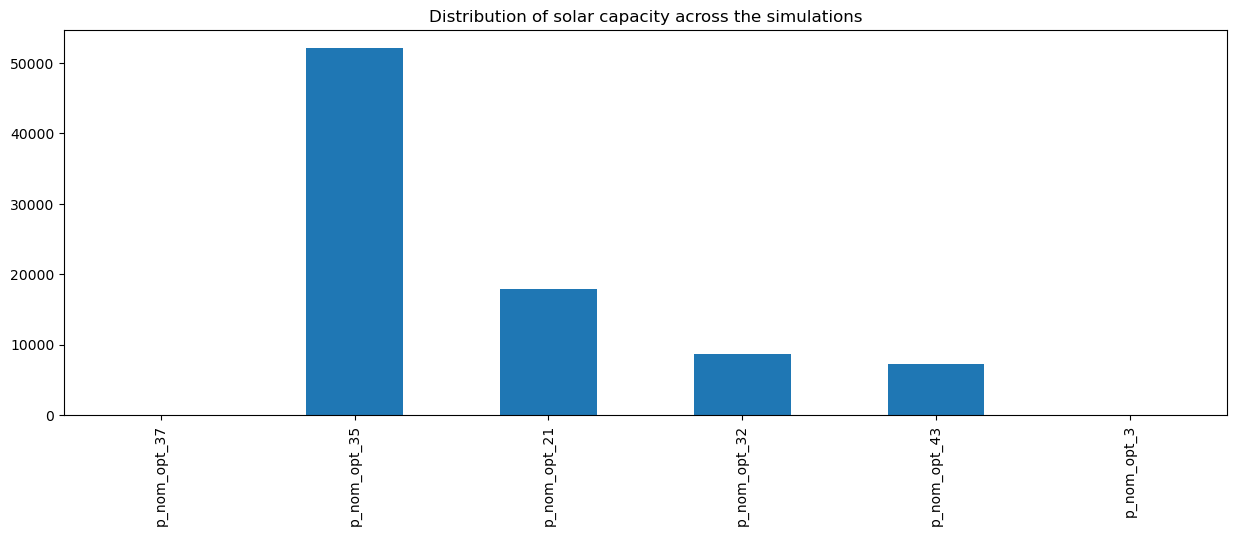

In [72]:
solar_generators = pd.concat([network_list[37].generators[network_list[37].generators.index.str.contains('solar')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_37"}),
                             network_list[35].generators[network_list[35].generators.index.str.contains('solar')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_35"}),
                             network_list[21].generators[network_list[21].generators.index.str.contains('solar')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_21"}),
                             network_list[32].generators[network_list[32].generators.index.str.contains('solar')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_32"}),
                             network_list[43].generators[network_list[43].generators.index.str.contains('solar')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_43"}),
                             network_list[3].generators[network_list[3].generators.index.str.contains('solar')][["p_nom_opt"]].rename(columns={"p_nom_opt": "p_nom_opt_3"})],
                            axis=1)
solar_generators.sum().plot(kind="bar", figsize=(15,5))
plt.title("Distribution of solar capacity across the simulations")
plt.show()

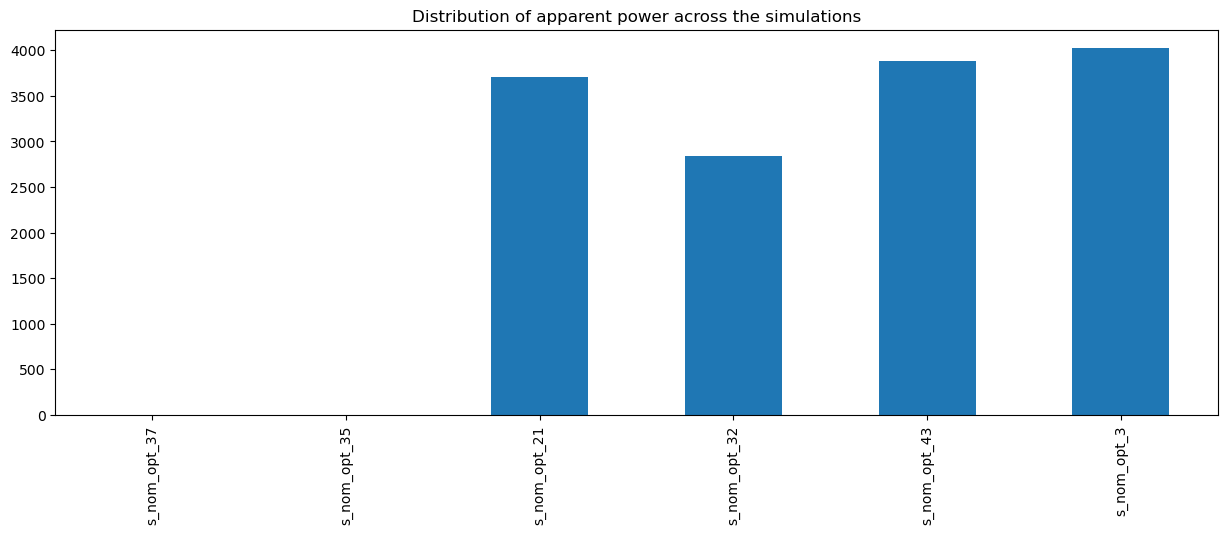

In [71]:
opt_apparent_power = pd.concat([network_list[37].lines[["s_nom_opt"]].rename(columns={"s_nom_opt": "s_nom_opt_37"}),
           network_list[35].lines[["s_nom_opt"]].rename(columns={"s_nom_opt": "s_nom_opt_35"}),
           network_list[21].lines[["s_nom_opt"]].rename(columns={"s_nom_opt": "s_nom_opt_21"}),
           network_list[32].lines[["s_nom_opt"]].rename(columns={"s_nom_opt": "s_nom_opt_32"}),
           network_list[43].lines[["s_nom_opt"]].rename(columns={"s_nom_opt": "s_nom_opt_43"}),
           network_list[3].lines[["s_nom_opt"]].rename(columns={"s_nom_opt": "s_nom_opt_3"})
], axis=1)

opt_apparent_power.sum().plot(kind="bar", figsize=(15,5))
plt.title("Distribution of apparent power across the simulations")
plt.show()

35,37,21,32,43,3

Text(0.5, 1.0, 'p_max_pu for onwind generators')

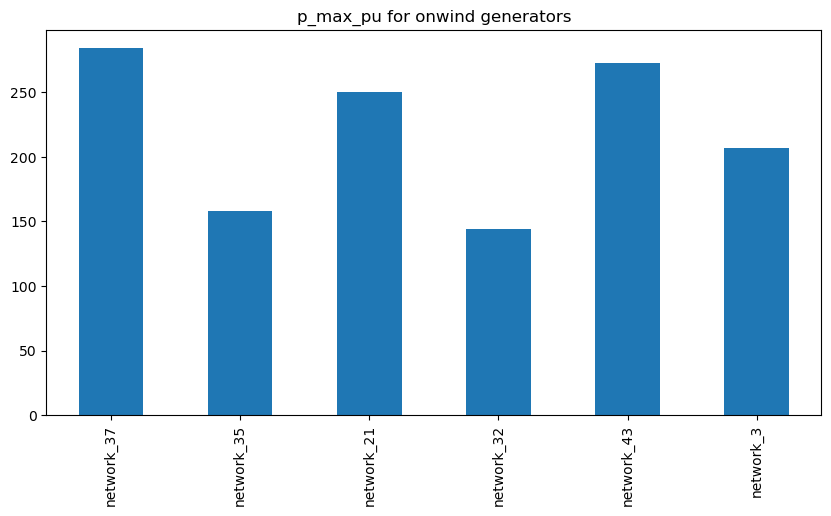

In [58]:
p_max_generator_onwind = pd.concat([network_list[37].generators_t.p_max_pu.sum()[network_list[37].generators_t.p_max_pu.columns.str.contains("onwind")].rename("network_37"),
           network_list[35].generators_t.p_max_pu.sum()[network_list[35].generators_t.p_max_pu.columns.str.contains("onwind")].rename("network_35"),
           network_list[21].generators_t.p_max_pu.sum()[network_list[21].generators_t.p_max_pu.columns.str.contains("onwind")].rename("network_21"),
           network_list[32].generators_t.p_max_pu.sum()[network_list[32].generators_t.p_max_pu.columns.str.contains("onwind")].rename("network_32"),
           network_list[43].generators_t.p_max_pu.sum()[network_list[43].generators_t.p_max_pu.columns.str.contains("onwind")].rename("network_43"), 
           network_list[3].generators_t.p_max_pu.sum()[network_list[3].generators_t.p_max_pu.columns.str.contains("onwind")].rename("network_3")], axis=1)

p_max_generator_onwind.sum().plot(kind="bar", figsize=(10,5))
plt.title("p_max_pu for onwind generators")

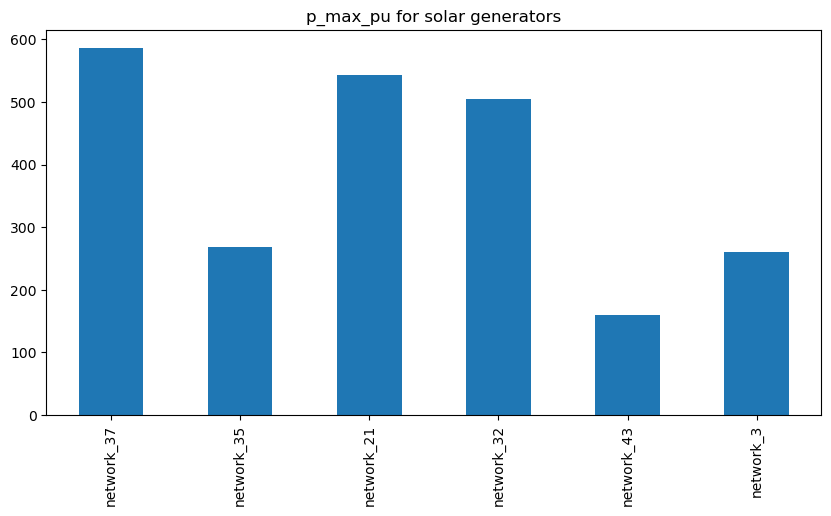

In [70]:
p_max_generator_solar = pd.concat([network_list[37].generators_t.p_max_pu.sum()[network_list[37].generators_t.p_max_pu.columns.str.contains("solar")].rename("network_37"),
           network_list[35].generators_t.p_max_pu.sum()[network_list[35].generators_t.p_max_pu.columns.str.contains("solar")].rename("network_35"),
           network_list[21].generators_t.p_max_pu.sum()[network_list[21].generators_t.p_max_pu.columns.str.contains("solar")].rename("network_21"),
           network_list[32].generators_t.p_max_pu.sum()[network_list[32].generators_t.p_max_pu.columns.str.contains("solar")].rename("network_32"),
           network_list[43].generators_t.p_max_pu.sum()[network_list[43].generators_t.p_max_pu.columns.str.contains("solar")].rename("network_43"), 
           network_list[3].generators_t.p_max_pu.sum()[network_list[3].generators_t.p_max_pu.columns.str.contains("solar")].rename("network_3")], axis=1)

p_max_generator_solar.sum().plot(kind="bar", figsize=(10,5))
plt.title("p_max_pu for solar generators")
plt.show()

35,37,21,32,43,3

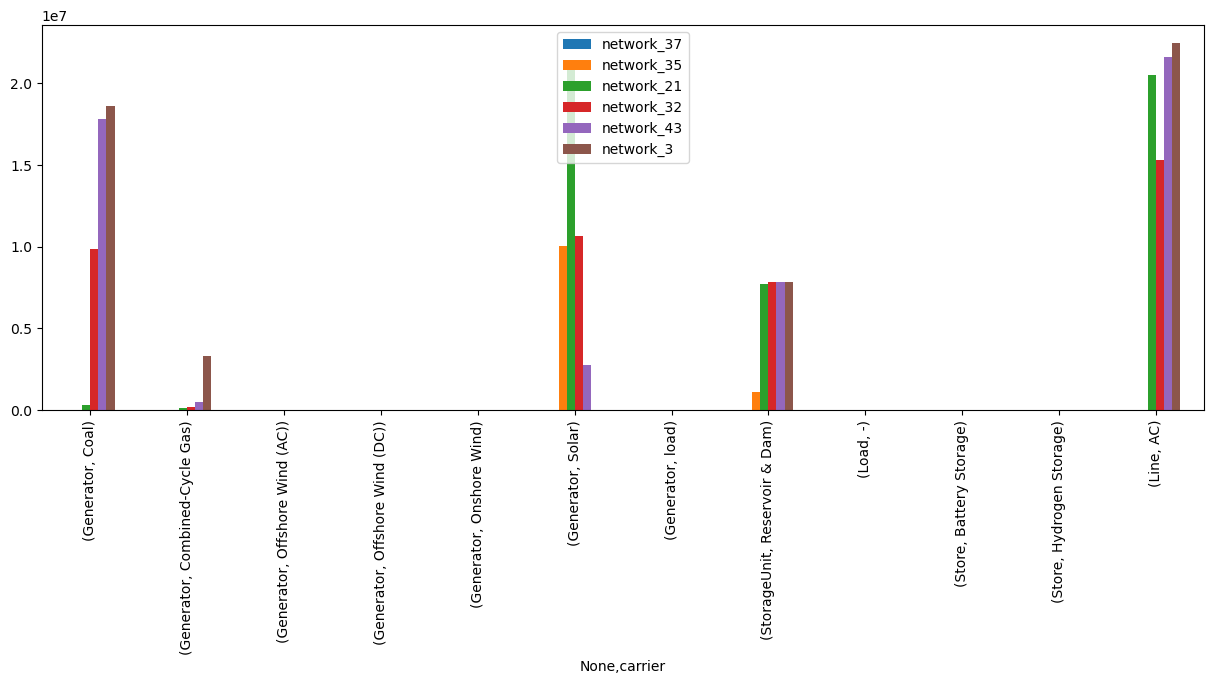

In [69]:
supply_df = pd.concat([network_list[37].statistics.supply().rename("network_37"), 
           network_list[35].statistics.supply().rename("network_35"),
           network_list[21].statistics.supply().rename("network_21"),
           network_list[32].statistics.supply().rename("network_32"),
           network_list[43].statistics.supply().rename("network_43"),
           network_list[3].statistics.supply().rename("network_3")], axis=1)

supply_df.plot(kind="bar", figsize=(15,5))
plt.show()

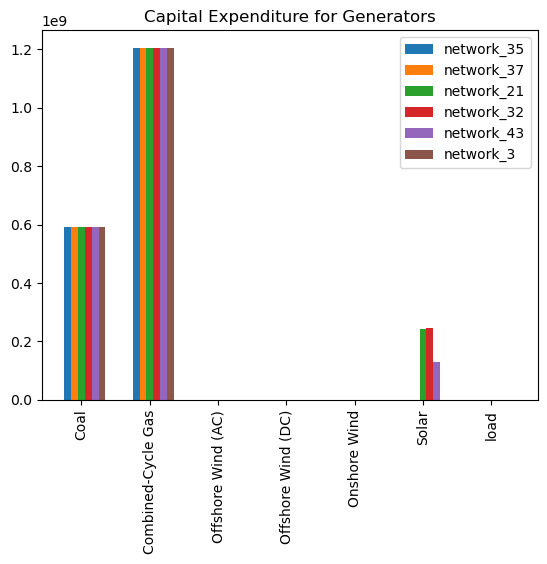

In [372]:
labels = network_list[3].statistics()["Capital Expenditure"].loc["Generator"].index.tolist()

x_axis_labels = np.arange(len(labels))

plt.bar(x_axis_labels - 0.2, network_list[35].statistics()["Capital Expenditure"].loc["Generator"], 0.1, label="network_35")
plt.bar(x_axis_labels - 0.1, network_list[37].statistics()["Capital Expenditure"].loc["Generator"], 0.1, label="network_37")
plt.bar(x_axis_labels, network_list[21].statistics()["Capital Expenditure"].loc["Generator"], 0.1, label="network_21")
plt.bar(x_axis_labels + 0.1, network_list[32].statistics()["Capital Expenditure"].loc["Generator"], 0.1, label="network_32")
plt.bar(x_axis_labels + 0.2, network_list[43].statistics()["Capital Expenditure"].loc["Generator"], 0.1, label="network_43")
plt.bar(x_axis_labels + 0.3, network_list[3].statistics()["Capital Expenditure"].loc["Generator"], 0.1, label="network_3")
plt.xticks(x_axis_labels, labels,rotation=90) 
plt.title("Capital Expenditure for Generators")
plt.legend()
plt.show()

## Producing the post-processed coefficients from the solved networks

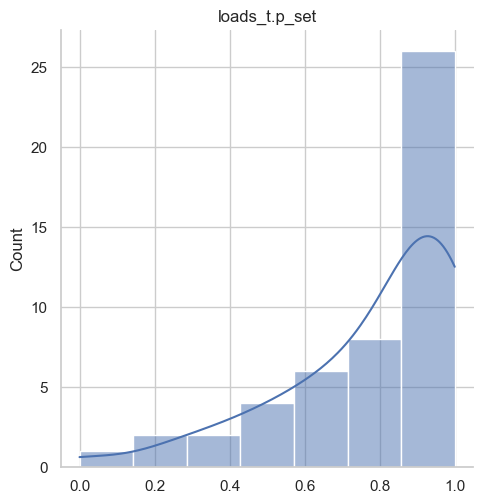

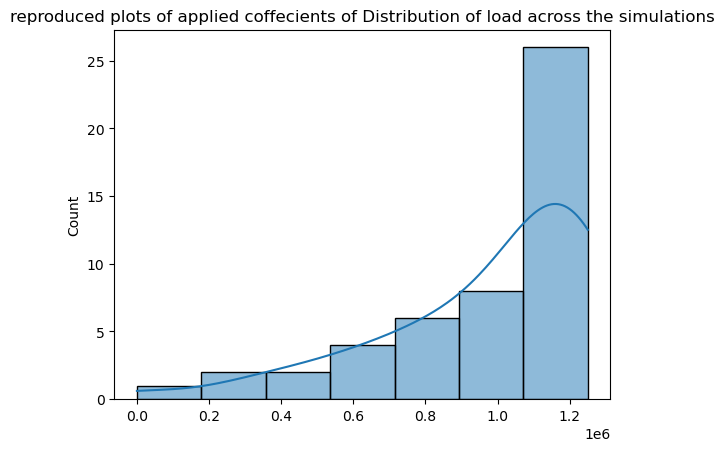

In [77]:
load_list = []
for idx in network_list:
    load_list_idx = idx.loads_t.p_set.sum().sum()
    load_list.append(load_list_idx)

    
sorted(load_list)
sns.histplot(load_list, kde=True)
plt.title("reproduced plots of applied coffecients of Distribution of load across the simulations")
Image(filename='loads_t.p_set.png')

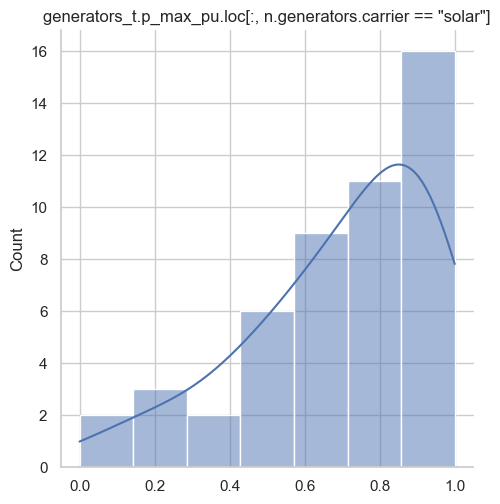

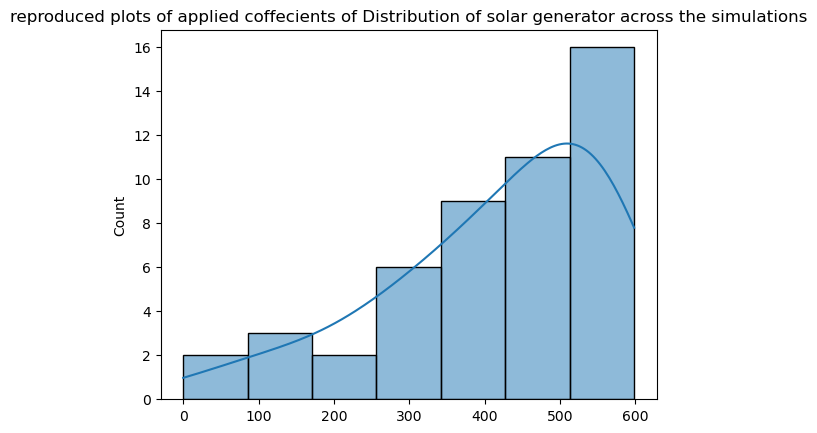

In [76]:
solar_generators = []
for idx in network_list:
    solar_generators_idx = idx.generators_t.p_max_pu.loc[:, idx.generators.carrier == "solar"].sum().sum()
    solar_generators.append(solar_generators_idx)

    
sorted(solar_generators)
sns.histplot(solar_generators, kde=True)
plt.title("reproduced plots of applied coffecients of Distribution of solar generator across the simulations")
Image(filename='generators_t.p_max_pu.loc[:, n.generators.carrier == "solar"].png')

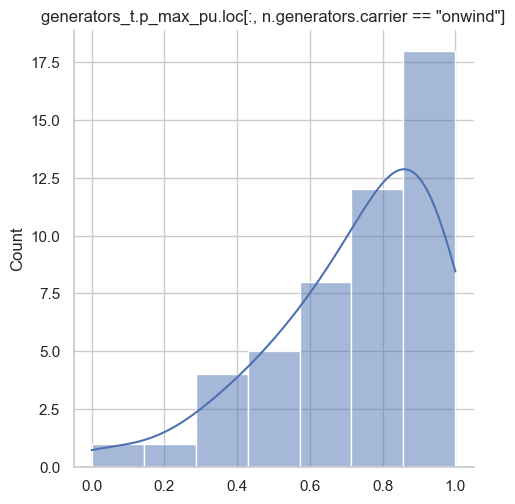

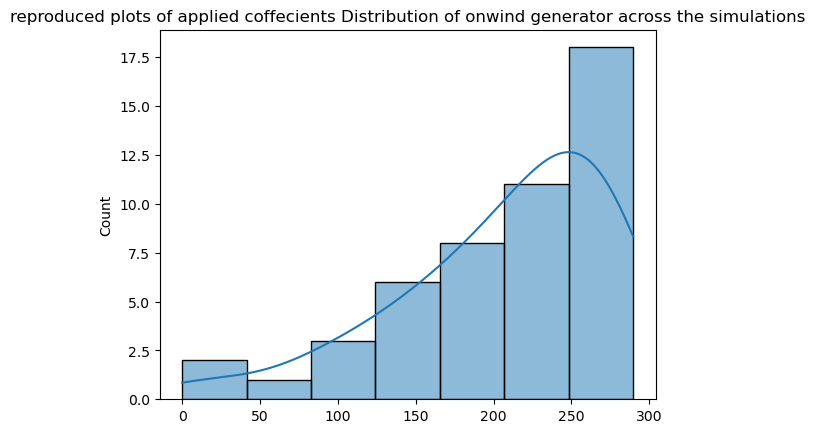

In [75]:
onwind_generators = []
for idx in network_list:
    onwind_generators_idx = idx.generators_t.p_max_pu.loc[:, idx.generators.carrier == "onwind"].sum().sum()
    onwind_generators.append(onwind_generators_idx)

    
sorted(onwind_generators)
sns.histplot(onwind_generators, kde=True)
plt.title("reproduced plots of applied coffecients Distribution of onwind generator across the simulations")
Image(filename='generators_t.p_max_pu.loc[:, n.generators.carrier == "onwind"].png')

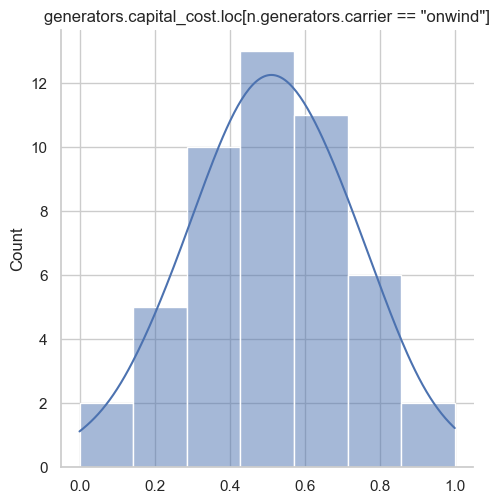

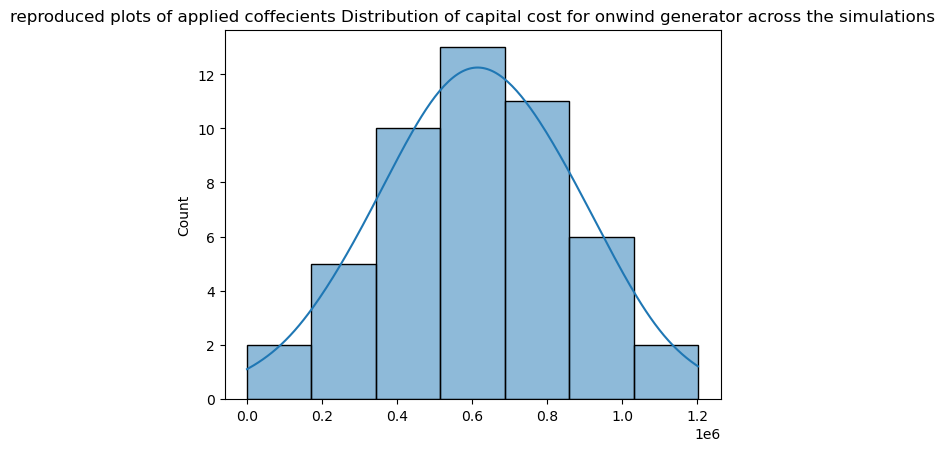

In [74]:
capital_cost_onwind_generators = []
for idx in network_list:
    capital_cost_onwind_generators_idx = idx.generators.capital_cost.loc[idx.generators.carrier == "onwind"].sum().sum()
    capital_cost_onwind_generators.append(capital_cost_onwind_generators_idx)

    
sorted(capital_cost_onwind_generators)
sns.histplot(capital_cost_onwind_generators, kde=True)
plt.title("reproduced plots of applied coffecients Distribution of capital cost for onwind generator across the simulations")
Image(filename='generators.capital_cost.loc[n.generators.carrier == "onwind"].png')

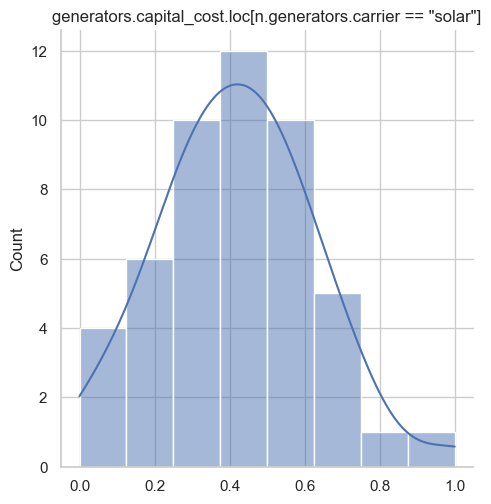

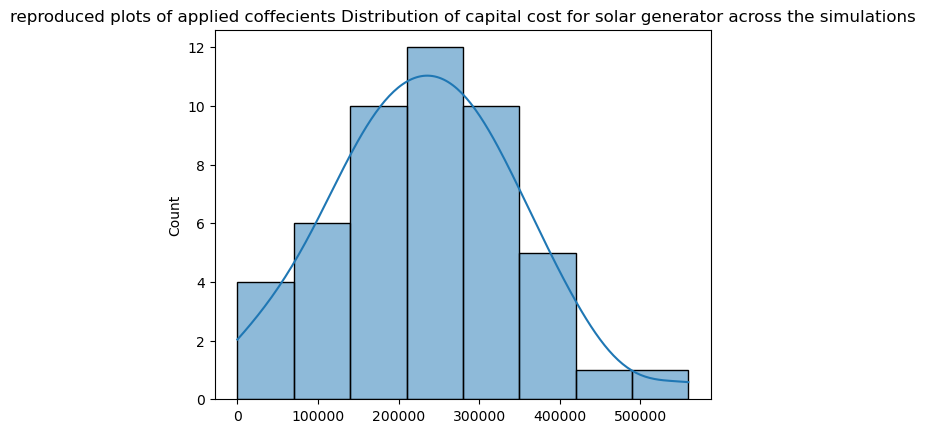

In [78]:
capital_cost_solar_generators = []
for idx in network_list:
    capital_cost_solar_generators_idx = idx.generators.capital_cost.loc[idx.generators.carrier == "solar"].sum().sum()
    capital_cost_solar_generators.append(capital_cost_solar_generators_idx)

    
sorted(capital_cost_solar_generators)
sns.histplot(capital_cost_solar_generators, kde=True)
plt.title("reproduced plots of applied coffecients Distribution of capital cost for solar generator across the simulations")
Image(filename='generators.capital_cost.loc[n.generators.carrier == "solar"].png')

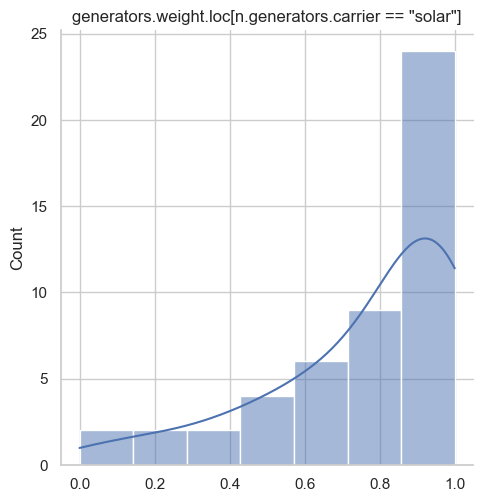

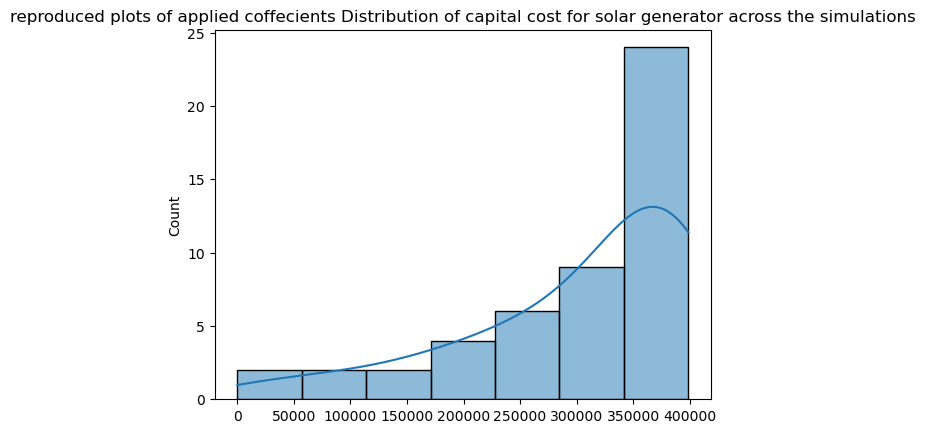

In [79]:
weight_solar_generators = []
for idx in network_list:
    weight_solar_generators_idx = idx.generators.weight.loc[idx.generators.carrier == "solar"].sum().sum()
    weight_solar_generators.append(weight_solar_generators_idx)

    
sorted(weight_solar_generators)
sns.histplot(weight_solar_generators, kde=True)
plt.title("reproduced plots of applied coffecients Distribution of capital cost for solar generator across the simulations")
Image(filename='generators.weight.loc[n.generators.carrier == "solar"].png')

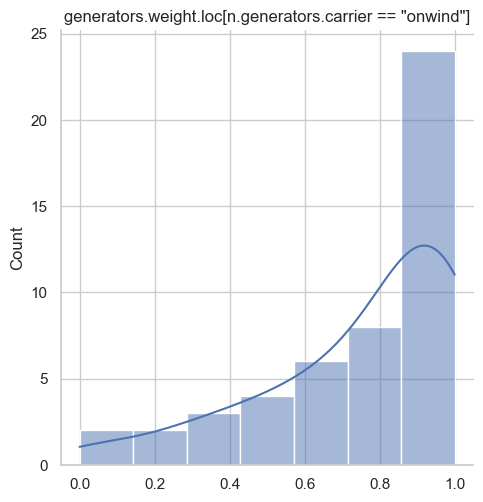

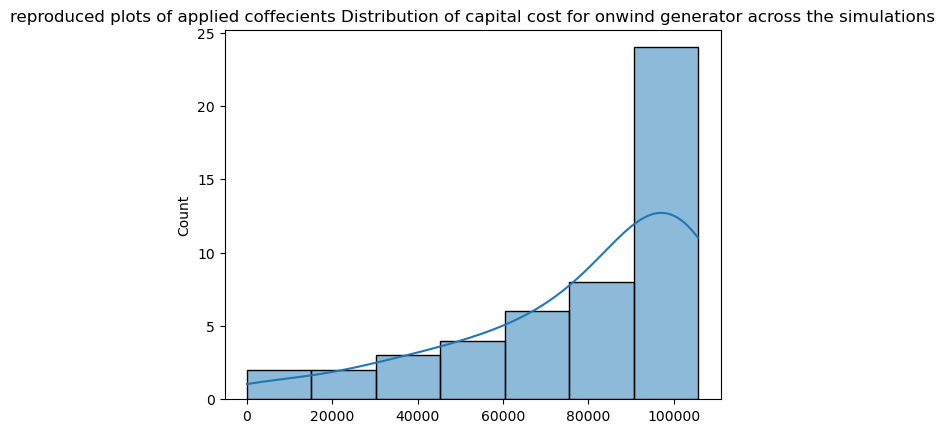

In [80]:
weight_onwind_generators = []
for idx in network_list:
    weight_onwind_generators_idx = idx.generators.weight.loc[idx.generators.carrier == "onwind"].sum().sum()
    weight_onwind_generators.append(weight_onwind_generators_idx)

    
sorted(weight_onwind_generators)
sns.histplot(weight_onwind_generators, kde=True)
plt.title("reproduced plots of applied coffecients Distribution of capital cost for onwind generator across the simulations")
Image(filename='generators.weight.loc[n.generators.carrier == "onwind"].png')

# Conclusion

The simulation results highlight the variability in power generation, load distribution, and associated costs across different scenarios. These findings can be valuable for decision-making and optimization in the energy sector.